In [1]:
# Remove processed data dirs
import os
import shutil

for x in os.walk("../data/"):
    if "processed" in x[0]:
        print(x[0])
        #shutil.rmtree(x[0])

../data/test_set_rot/processed
../data/test_set/processed
../data/old_training_set/processed
../data/val_set/processed
../data/5st_test_rot/processed
../data/train_set/processed


In [1]:
#Generate Energy List
import forgi.threedee.model.coarse_grain as ftmc
import os

def get_rmsd_dict(rmsd_list):
    rmsd_dict = {}
    with open(rmsd_list, "r") as fh:
        for line in fh.readlines():
            name, rmsd = (line.rstrip()).split("\t")
            rmsd_dict[name] = float(rmsd)
    return rmsd_dict

rmsd_dict = get_rmsd_dict("../data/train_rmsd_list.txt")

file_path = "../data/train_set/" #"../data/old_training_set/" # "../data/val_set/"#"../data/test_set/" #

energy_file = "../data/train_energy.txt" #"../data/old_train_energy.txt"#"../data/val_energy.txt"#"../data/test_energy.txt" #

write = False

#file = "../data/train_set/1c2x_C_5srRNA_C_br0.cg"
c_files = 0
c_has = 0
c_not = 0
pos_e = 0
lines = []
for file in [f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))]:
    if file in rmsd_dict.keys():
        cg = ftmc.CoarseGrainRNA.from_bg_file(file_path + file)
        cg.radius_of_gyration
        energy = cg.infos['Energy']
    
        c_files += 1
        if energy == []:
            c_not += 1
            print(file, energy, cg.radius_of_gyration(method="vres"), rmsd_dict[file])
        elif "ROG" in energy[0]:
            c_has +=1
            rog_en = energy[0].split(",")[0][:-4]
            if float(rog_en) > 0:
                print(file, rog_en)
                pos_e +=1
            line = file + "\t" + rog_en + "\n"
            lines.append(line)

    

print("files", c_files)
print("ROG energy", c_has)
print("Positive energy", pos_e)
print("no energy", c_not)
print(c_has + c_not)

if write:
    with open(energy_file, "w") as fh:
        for l in lines:
            fh.write(l)


5jb3_4_tRNA_4_rn37.cg 27.0104767369
5b63_D_tRNA_D_rn08.cg 64.0838032945
6k0b_U_tRNA_U_rn11.cg 39.586131714
6lvr_D_tRNA_D_rn01.cg 29.8298596023
5k0y_N_tRNA_N_rn13.cg 74.8848142841
6lvr_D_tRNA_D_rn12.cg 21.6095902173
5zeu_v_tRNA_v_rn01.cg 47.9036863609
5jb3_4_tRNA_4_rn36.cg 27.7795264098
6o7k_v_tRNA_v_rn39.cg 64.0447165913
5x6b_P_tRNA_P_rn23.cg 69.3117391568
5v6x_C_tRNA_C_rn02.cg 80.9802071478
5ud5_D_tRNA_D_rn39.cg 85.3513468946
7k98_F_tRNA_F_rn24.cg 66.7130875195
6k0b_U_tRNA_U_rn29.cg 35.8342546946
5v6x_C_tRNA_C_rn32.cg 70.3367641012
5yyn_D_tRNA_D_rn15.cg 61.6357118585
6i0y_V_tRNA_V_rn37.cg 51.4564633925
5v6x_D_tRNA_D_rn07.cg 94.3000184339
5ud5_D_tRNA_D_rn34.cg 104.442493749
5b63_D_tRNA_D_rn27.cg 53.4184679622
5cd1_M_tRNA_M_rn25.cg 45.3309421521
1nkw_9_5srRNA_9_br0.cg [] 31.192492947248695 0.317
6o7k_v_tRNA_v_rn11.cg 2.35802478693
5b63_D_tRNA_D_rn34.cg 72.7710165321
5v6x_C_tRNA_C_rn37.cg 80.8045901094
5b63_D_tRNA_D_rn37.cg 57.2734354108
6k0b_V_tRNA_V_rn40.cg 61.8663949081
5x6b_P_tRNA_P_

In [2]:
#Rotate cg structures
import forgi.threedee.model.coarse_grain as ftmc
import forgi.threedee.utilities.vector as ftuv
import forgi.utilities.commandline_utils as fuc
import os

directory = "../data/old_training_set/"
out_dir = "../data/5st_test_rot/"
angle = 1.5708


for file in [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]:

    cgf = ftmc.CoarseGrainRNA.from_bg_file(directory + file)
    cgf.rotate(angle)

    with fuc.open_for_out(out_dir + file) as outfile:
        print(cgf.to_cg_string(), file=outfile)

min(s1_x_list) = -33.66219107773895
np.quantile(s1_x_list, q=0.25) = -4.677402472441415
np.median(s1_x_list) = 0.5052105639769833
np.quantile(s1_x_list, q=0.75) = 5.691692494479424
max(s1_x_list) = 34.08763855976298


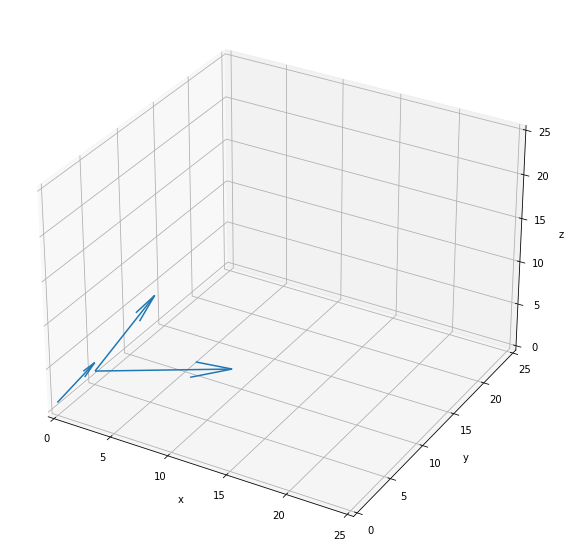

In [51]:
# get s0 and one connecting element (i0 > m0 > i? > m?) into one fixed plane
import forgi.threedee.model.coarse_grain as ftmc
import forgi.threedee.utilities.vector as ftuv
import forgi.utilities.commandline_utils as fuc
import forgi.threedee.classification.aminor as ftca
import forgi.threedee.model as ftm
import os
import numpy as np
import math


def elem_len(cg_d: dict, elem: str) -> float:
    return math.sqrt((cg_d[elem][1][0] - cg_d[elem][0][0])**2 + (cg_d[elem][1][1] - cg_d[elem][0][1])**2 + (cg_d[elem][1][2] - cg_d[elem][0][2])**2)

def s0_dist(cg_d: dict) -> np.ndarray:
    ideal_start = np.array([0, 0, 1])
    return cg_d["s0"][0] - ideal_start

def s0_angle(cg_d: dict) -> np.ndarray:
    s0_len = elem_len(cg_d, "s0")
    A = np.array([0, s0_len, 1])
    B = np.array([0, 0, 1])
    ba = A - B
    s0_vec = cg_d["s0"][1] - cg_d["s0"][0]
    return ftuv.get_alignment_matrix(ba, s0_vec)

def s1_angle(cg_d: dict) -> np.ndarray:
    vec1 = cg_d["s1"][0] - cg_d["s0"][1]
    n = np.array([1, 0, 0])
    proj_n = (np.dot(vec1, n) / np.linalg.norm(n)**2) * n
    vec2 = np.absolute(vec1 - proj_n)
    #print(f"{vec1 = }\n{proj_n = }\n{vec2 = }")

    len_v1 = np.linalg.norm(vec1)
    len_v2 = np.linalg.norm(vec2)
    

    angle = np.arccos(np.dot(vec1, vec2)/(len_v1 * len_v2))

    return angle, vec1, vec2

s1_x_list = []
directory = "../data/old_training_set/"
for file in [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]:

    cg = ftmc.CoarseGrainRNA.from_bg_file(directory + file)

    #cg = ftmc.CoarseGrainRNA.from_bg_file("../data/old_training_set/1asy_R_tRNA001.cg") 
    y_e = cg.coords["s0"][1][1]
    i_end = np.array([0, y_e, 1])

    # check if end of s0 is equal to convention. if not rotate structure
    if not np.array_equal(cg.coords["s0"][1], i_end):
        rot_s0 = s0_angle(dict(cg.coords))
        cg.rotate_translate([0, 0, 0], rot_s0)
    s1angle, v_m0, v_yzproj = s1_angle(dict(cg.coords))
    s0_len = elem_len(dict(cg.coords), "s0")
    v_s0 = np.array([0, s0_len, 1])
    #print(f"{s1angle = }\n{v_s0 = }\n{v_m0 = }\n{v_yzproj = }")
    cg.rotate(s1angle, axis="y")


    diff_start = s0_dist(dict(cg.coords))
    cg.rotate_translate(diff_start, [[1, 0, 0], [0, 1, 0], [0, 0, 1]]) #rot_s0)#

    s1_x_list.append(cg.coords["s1"][0][0])

    #inter = list(set(cg.connections("s0")).intersection(cg.connections("s1")))
    #print(f"{file}\ns0 : {cg.coords['s0']}\nm0 : {cg.coords[inter]}\ns1 : {cg.coords['s1']}")
    #cg.to_file("../../1asy_rot-trans.cg")


print(f"{min(s1_x_list) = }")
print(f"{np.quantile(s1_x_list, q=0.25) = }")
print(f"{np.median(s1_x_list) = }")
print(f"{np.quantile(s1_x_list, q=0.75) = }")
print(f"{max(s1_x_list) = }")




vectors = np.array([
    np.concatenate((np.array([0, 0, 1]), v_s0), axis=None),
    np.concatenate((v_s0, v_m0), axis=None),
    np.concatenate((v_s0, v_yzproj), axis=None)])

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
X, Y, Z, U, V, W = zip(*vectors)
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([0, 25])
ax.set_ylim([0, 25])
ax.set_zlim([0, 25])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()


In [56]:
# are s0 and s1 connected with an element, if yes which?
import os
import forgi.threedee.model.coarse_grain as ftmc

directory =  "../data/train_set/" #"../data/old_training_set/" #

c_dict = {}
for file in [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]:

    cg = ftmc.CoarseGrainRNA.from_bg_file(directory + file)

    #if cg.longrange_iterator():
    inter = list(set(cg.connections("s0")).intersection(cg.connections("s1")))

    if inter[0] not in c_dict:
        c_dict[inter[0]] = 1
    else:
        c_dict[inter[0]] +=1
    
    if len(inter) > 1:
        print("more")
    elif len(inter) == 0:
        print("no")

for key in c_dict:
    print(key, c_dict[key])

m0 2585
i0 275
i3 165


In [19]:
#get nearest k elements
#--> set of k vectors
#plus origin? ie middle of element
import forgi.threedee.model.coarse_grain as ftmc
import forgi.threedee.utilities.vector as ftuv
import forgi.utilities.commandline_utils as fuc
import os
import numpy as np


def k_neighbours(file):
    cg = ftmc.CoarseGrainRNA.from_bg_file(file)

    cg_d = dict(cg.coords)

    #calculate midpoint of each element
    mp_dir = {}
    for elem in cg_d:
        mp = (cg_d[elem][0] + cg_d[elem][1])/2
        mp_dir[elem] = mp

    for e in mp_dir:
        print(e, mp_dir[e])

    #calculate distance from each midpoint to every other
    dist_dir = {}
    for a in mp_dir:
        helper_d = {}
        for b in mp_dir:
            if a != b:
                dist = np.linalg.norm(mp_dir[b] - mp_dir[a])
                helper_d[b] = dist
        if helper_d != {}:
            dist_dir[a] = helper_d

    #get the nearest k=5 elements
    n_dict = {}
    for f in dist_dir:
        n_list = []
        #print(f, {k: v for k, v in sorted(dist_dir[f].items(), key=lambda item: item[1])})

        for i, n in enumerate({k: v for k, v in sorted(dist_dir[f].items(), key=lambda item: item[1])}):
            n_list.append(n)

            if i == 3:
                break
        n_dict[f] = n_list

    print(n_dict)

    for elem in n_dict:
            v_arr = []
            for e in n_dict[elem]:
                vec = []
                for i in range(3):
                    p = mp_dir[e][i] - mp_dir[elem][i]
                    vec.append(p)
                v_arr.append(np.array(vec))
            print(elem, np.concatenate(v_arr))

k_neighbours("../data/train_set/1c2x_C_5srRNA_C_be10.cg")

s0 [0.     8.9245 1.    ]
m0 [ 4.59102755 23.31909891  2.58395171]
s1 [ 9.14899228 27.50862663  4.24800654]
i0 [ 9.31876632 23.52742755  5.12067852]
s2 [ 9.85914283 18.2925279   5.95546788]
i1 [11.97891593 18.95004125 12.37592786]
s3 [10.75129627 21.21650161 20.93528831]
h0 [ 5.16043193 32.90573557 18.3901679 ]
m1 [ 9.76132007 31.47540551  3.9760168 ]
s4 [10.85353961 35.3099031   3.5278488 ]
i2 [10.50398669 45.12914478  7.43011927]
s5 [13.22877687 55.55225496 19.57039629]
h1 [18.26331436 53.22239035 32.22612492]
m2 [ 5.17029252 26.0053066   2.39206509]
t0 [ 4.8359959  -1.74050432  0.42341416]
{'s0': ['t0', 's2', 'm0', 'i0'], 'm0': ['m2', 'i0', 's1', 's2'], 's1': ['m1', 'i0', 'm2', 'm0'], 'i0': ['s1', 's2', 'm0', 'm2'], 's2': ['i0', 'i1', 'm0', 's1'], 'i1': ['s2', 's3', 'i0', 's1'], 's3': ['i1', 'h0', 's2', 'i0'], 'h0': ['s3', 'm1', 's1', 's4'], 'm1': ['s4', 's1', 'm2', 'i0'], 's4': ['m1', 's1', 'i2', 'm2'], 'i2': ['s4', 'm1', 's5', 'h0'], 's5': ['h1', 'i2', 'h0', 's4'], 'h1': ['s5', 'i

In [6]:
#Open lmdb files
import lmdb
import gzip
import json
import numpy as np
import pandas as pd
#import pdbtools

'''
b'id_to_idx'
b'num_examples'
b'serialization_format'
'''


lmdb_file = "/home/milan/Programs/ares_release/data/lmdbs/train/"
lmdb_env = lmdb.open(lmdb_file)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()

print(lmdb_env.stat())

idx = lmdb_cursor.get("idx_to_idx".encode())#.decode() #gzip.decompress(
print(idx)


i = gzip.decompress(lmdb_cursor.get("0".encode())).decode()

d = json.loads(i)

i_json = pd.read_json(i)

columns = i_json.iloc[0,0]
index = i_json.iloc[1,0]
data = i_json.iloc[2,0]

i_new = pd.DataFrame(data=data, index=index, columns=columns)

pdb_out = pd.DataFrame(i_new, columns=["serial_number", "subunit", "chain", "residue", "resname", "x", "y", "z", "element", "name"])

pdb_out.head()

{'psize': 4096, 'depth': 1, 'branch_pages': 0, 'leaf_pages': 1, 'overflow_pages': 256, 'entries': 53}
None


,serial_number,subunit,chain,residue,resname,x,y,z,element,name
0,1,0,A,1,C,7.278,9.150,14.138,C,C5'
1,2,0,A,1,C,6.457,10.282,13.572,C,C4'
2,3,0,A,1,C,7.273,11.210,12.812,O,O4'
3,4,0,A,1,C,5.459,9.762,12.567,C,C3'
4,5,0,A,1,C,4.329,9.250,13.226,O,O3'


In [1]:
#get list of representative RNA structures

rep_pdbs = []
with open("../data/nrlist_3.220_4.0A.csv", "r") as fh:
    for line in fh.readlines():
        equ = line.split(",")[0].lower().lstrip('"').rstrip('"')
        all = line.split(",")[1].lower().lstrip('"').rstrip('"')
        if "+" in all:
            l = all.split("+")
            for i in l:
                id = i.split("|")
                rep_pdbs.append(id+[equ])
        else:
            pdb = all.split("|")
            rep_pdbs.append(pdb+[equ])

rfam_pdbs = {}
with open("../data/Rfam.pdb", "r") as fh:
    for line in fh.readlines()[1:]:
        pdb = line.split("\t")
        rfam_pdbs[pdb[1]] = pdb


c = 0
nc = 0
lines = []
rmc_dict = {}
for item in rep_pdbs:
    if item[0] in rfam_pdbs.keys():
        c +=1
    else:
        nc +=1
    l = item[0] + "\t" + item[1] + "\t" + item[2] + "\t" + item[3] + "\n"
    lines.append(l)

    

#with open("../data/rep_rfam_list.txt", "w") as fh:
#    for line in lines:
#        fh.write(line)

print(rep_pdbs[0])
print("len rep pdbs", len(rep_pdbs))
print("len rfam pdbs", len(rfam_pdbs))
print("rep in rfam", c)
print("rep not in rfam", nc)

for k in sorted(rmc_dict):
    print(k, rmc_dict[k])


['4v9q', '1', 'dv', 'nr_4.0_29909.1']
len rep pdbs 2862
len rfam pdbs 2305
rep in rfam 656
rep not in rfam 2206


In [36]:
rep_pdbs = []
with open("../data/nrlist_3.220_4.0A.csv", "r") as fh:
    for line in fh.readlines():
        all = line.split(",")[1].lower().lstrip('"').rstrip('"')
        if "+" in all:
            l = all.split("+")
            for i in l:
                id = i.split("|")
                rep_pdbs.append(id)
        else:
            pdb = all.split("|")
            rep_pdbs.append(pdb)

print(len(rep_pdbs))
with open("../data/reprna_list.txt", "w") as fh:
    for n in rep_pdbs:
        fh.write("\t".join(n) + "\n")

2862


In [19]:
# translate nr numbers into readable representations
id_dict= {}
with open("../../rep_rna_list.csv", "r") as fh:
    for line in fh.readlines()[1:]:
        num, equ, rep = line.split(",")
        
        id = equ.split(";")[0]
        rna_id = rep.split(";")[1]
        
        if rna_id not in id_dict.keys():
            id_dict[rna_id] = [id]
        else:
            id_dict[rna_id].append(id)

lines = []
for key in id_dict:
    if len(id_dict[key]) == 1:
        l = f"{str(key)}\t\t\t{id_dict[key][0]}\n"
        lines.append(l)
    else:
        nrs = (", ").join(id_dict[key])
        l = f"{str(key)}\t\t\t{nrs}\n"
        lines.append(l)


with open("../data/rep_rna_trans.txt", "w") as fh:
    for line in lines:
        fh.write(line)


In [23]:
rep_dict = {}
with open("../data/rep_rna_trans.txt", "r") as fh:
    for line in fh.readlines():
        rep, num = line.split("\t\t\t")
        if rep not in rep_dict:
            if "," in num:
                n = num.rstrip("\n").split(",")
            else:
                n = [num.rstrip("\n")]
            rep_dict[rep] = n
        else:
            if "," in num:
                n = num.rstrip("\n").split(",")
            else:
                n = [num.rstrip("\n")]
            rep_dict[rep] += n

for key in rep_dict:
    print(key, rep_dict[key])

lines = []
for key in sorted(rep_dict):
    if len(rep_dict[key]) == 1:
        l = f"{str(key)}\t\t\t{rep_dict[key][0]}\n"
        lines.append(l)
    else:
        nrs = (", ").join(rep_dict[key])
        l = f"{str(key)}\t\t\t{nrs}\n"
        lines.append(l)


with open("../data/rep_rna_trans.txt", "w") as fh:
    for line in lines:
        fh.write(line)

  RNA (5'-R(*(GCP)P*G)-3') ['NR_4.0_96460.1']
  RNA (5'-R(*GP*UP*C)-D(P*U)-R(P*CP*CP*UP*[...] ['NR_4.0_84831.1']
  RNA (5'-D(*(ATP))-R(P*A)-3') ['NR_4.0_60897.1']
  RNA (5'-D(*(GTG))-R(P*A)-3') ['NR_4.0_36733.1']
  5'-R(*CP*(5AA)*(HFA))-3' ['NR_4.0_35535.1']
  RNA (5'-R(*(6MZ)P*C)-3') ['NR_4.0_33222.1', '     NR_4.0_19822.1', '     NR_4.0_63313.1', '     NR_4.0_10291.1']
  m7G-capped RNA ['NR_4.0_23607.1']
  O2'methyl-RNA ['NR_4.0_01981.1']
  RNA (5'-R(P*GP*G)-3') ['NR_4.0_98428.1']
  RNA (5'-R(P*CP*U)-3') ['NR_4.0_96254.1']
  RNA (5'-R(P*AP*G)-3') ['NR_4.0_94833.3']
  RNA 3-mer (de novo synthesized) ['NR_4.0_93339.3']
  RNA (5'-R(P*AP*GP*G)-3') ['NR_4.0_80196.1']
  DNA (5'-R(*GP*U)-3') ['NR_4.0_78372.4']
  RNA (5'-D(*(APC))-R(P*GP*U)-3') ['NR_4.0_77810.2']
  RNA (5'-D(*(ATP))-R(P*AP*A)-3') ['NR_4.0_73502.1']
  DNA/RNA (5'-D(*IP*)-R(*CP*)-D(*IP*)-R(*C[...] ['NR_4.0_70203.1']
  RNA (5'-R(P*AP*GP*CP*A)-3') ['NR_4.0_68310.1']
  5'-R(UP*A)-3') ['NR_4.0_65802.1']
  RNA/DNA chimera (5'-D(CP*

In [20]:
#is it possible to get elements interacting in 3d space?
import forgi.threedee.model.coarse_grain as ftmc
import forgi.threedee.utilities.vector as ftuv
import forgi.threedee.utilities as ftu
import forgi.utilities.commandline_utils as fuc
import forgi.threedee.classification.aminor as ftca
import forgi.threedee.utilities._dssr as ftud
import os
import numpy as np
import subprocess


directory = "../data/train_set/"

#dssr = ftud.DSSRAnnotation()

for i, file in enumerate([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]):
    cg = ftmc.CoarseGrainRNA.from_bg_file(directory + file) #("../../PDBs/3f2q/best_rmsd0.coord")

    #dssr = dict(subprocess.check_output(["x3dna-dssr", f"-i={directory+file}", "--json"]))
    cg_d = dict(cg.coords)
    #print(dssr)
    print(file)
    #A-minor interactions
    for pair in ftca.all_interactions(cg):
        print(pair)
    
    #print(ftud.DSSRAnnotation(dssr=dssr ,cg=cg))
    #for elem in cg.sorted_element_iterator():
    #    print(elem, cg.connections(elem))
    
    #print(ftca.all_interactions(cg))

    

    if i == 5:
        break

test = "../data/train_set/6k0b_U_tRNA_U_br0.cg"
print(test)
tcg =  ftmc.CoarseGrainRNA.from_bg_file(test)
s3_c = dict(tcg.coords)["s3"]
print(s3_c)
print(s3_c[1] - s3_c[0])
print(dict(tcg.twists)["s3"])
k_neighbours(test)
for pair in ftca.all_interactions(tcg):
    print(pair)

5jb3_4_tRNA_4_rn37.cg
['h0' 's0']
5b63_D_tRNA_D_rn08.cg
5jb3_4_tRNA_4_be41.cg
['h2' 's0']
6k0b_U_tRNA_U_rn11.cg
2zjq_Y_5srRNA_Y_rn04.cg
['i0' 's0']
['i1' 's1']
['i3' 's7']
['h0' 's3']
['h1' 's5']
6lvr_D_tRNA_D_rn01.cg
['h0' 's3']
../data/train_set/6k0b_U_tRNA_U_br0.cg
(array([-25.76317269,  31.68715453,  -8.25223647]), array([-30.75040103,  31.07632259,  -9.20482966]))
[-4.98722834 -0.61083194 -0.95259319]
(array([-0.16315342, -0.18053565,  0.96994218]), array([-0.20529093,  0.80253204,  0.56017673]))
s0 [0.    7.651 1.   ]
m0 [-12.50775441  18.10406515  -5.00822183]
s1 [-22.6683082   20.60696036 -10.04721946]
h0 [-12.64074915  28.21824866  -7.18216431]
m1 [-27.590962    21.30589056 -13.7688787 ]
s2 [-33.35739715  20.43016018 -18.2134981 ]
h1 [-44.18344708  16.19399881 -24.65905281]
m2 [-27.96479393  26.69640268 -12.38677511]
s3 [-28.25678686  31.38173856  -8.72853306]
h2 [-34.66785315  33.85200233 -10.59142196]
m3 [-14.3498159   26.01993221  -2.521044  ]
s4 [-4.87033443 25.06221081  3

In [31]:
from Bio import SeqIO
from Bio import PDB


with open("../../PDBs/train_set_5st/1asy_R_tRNA.pdb") as fh:
    for line in fh.readlines():
        if line[:4] == "ATOM":
            print(line.rstrip())



OP3
P
OP1
OP2
O5'
C5'
C4'
O4'
C3'
O3'
C2'
O2'
C1'
N1
C2
O2
N3
C4
O4
C5
C6
P
OP1
OP2
O5'
C5'
C4'
O4'
C3'
O3'
C2'
O2'
C1'
N1
C2
O2
N3
C4
N4
C5
C6
P
OP1
OP2
O5'
C5'
C4'
O4'
C3'
O3'
C2'
O2'
C1'
N1
C2
O2
N3
C4
N4
C5
C6
P
OP1
OP2
O5'
C5'
C4'
O4'
C3'
O3'
C2'
O2'
C1'
N9
C8
N7
C5
C6
O6
N1
C2
N2
N3
C4
P
OP1
OP2
O5'
C5'
C4'
O4'
C3'
O3'
C2'
O2'
C1'
N1
C2
O2
N3
C4
O4
C5
C6
P
OP1
OP2
O5'
C5'
C4'
O4'
C3'
O3'
C2'
O2'
C1'
N9
C8
N7
C5
C6
O6
N1
C2
N2
N3
C4
P
OP1
OP2
O5'
C5'
C4'
O4'
C3'
O3'
C2'
O2'
C1'
N9
C8
N7
C5
C6
N6
N1
C2
N3
C4
P
OP1
OP2
O5'
C5'
C4'
O4'
C3'
O3'
C2'
O2'
C1'
N1
C2
O2
N3
C4
O4
C5
C6
P
OP1
OP2
O5'
C5'
C4'
O4'
C3'
O3'
C2'
O2'
C1'
N9
C8
N7
C5
C6
N6
N1
C2
N3
C4
P
OP1
OP2
O5'
C5'
C4'
O4'
C3'
O3'
C2'
O2'
C1'
N9
C8
N7
C5
C6
O6
N1
C2
N2
N3
C4
P
OP1
OP2
O5'
C5'
C4'
O4'
C3'
O3'
C2'
O2'
C1'
N1
C2
O2
N3
C4
O4
C5
C6
P
OP1
OP2
O5'
C5'
C4'
O4'
C3'
O3'
C2'
O2'
C1'
N1
C2
O2
N3
C4
O4
C5
C6
N1
C2
N3
C4
C5
C6
O2
O4
C1'
C2'
O2'
C3'
C4'
O3'
O4'
C5'
O5'
P
OP1
OP2
P
OP1
OP2
O5'
C5'
C4'
O4'
C3'
O3'
C2'
O2'
C1'
N